<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/jakob/Berechnen_der_Pixel_Anzahl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *


In [3]:
#ausführen
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [4]:
#ausführen
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

# Dataloaders with batch size 4
dls4 = parks_block.dataloaders(dataset_path, bs=4)

# Dataloaders with batch size 16
dls16 = parks_block.dataloaders(dataset_path, bs=16)

# Dataloaders with batch size 32
dls32 = parks_block.dataloaders(dataset_path, bs=32)


In [5]:
#dls16.show_batch(figsize=(15, 15), max_n=4)

In [6]:
##

def create_and_train_learner(dl, arch=resnet34, metrics=Dice, monitor='dice', epcohs=40, fname='model', act_cls=torch.nn.modules.activation.ReLU):
  learn = unet_learner(dl, arch, metrics=metrics, act_cls=act_cls)
  lr = learn.lr_find()
  learn.fit_one_cycle(40, lr_max=lr.valley, cbs=[
      EarlyStoppingCallback(monitor=monitor,
                            min_delta=0.01,
                            patience=10,
                            comp=np.greater),
      SaveModelCallback(monitor=monitor,
                        min_delta=0.01,
                        comp=np.greater,
                        fname=fname)])
  return learn

In the next sections we will experiment with different activation functions (ELU, LeakyReLU, GELU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 19 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

Finally we will unfreeze and train the last layers of the best model and export it.

In [7]:
#ausführen
path = Path('./gdrive/MyDrive/Capstone')
path.ls()

(#6) [Path('gdrive/MyDrive/Capstone/Literature'),Path('gdrive/MyDrive/Capstone/TDS2.pdf'),Path('gdrive/MyDrive/Capstone/Data'),Path('gdrive/MyDrive/Capstone/park_images'),Path('gdrive/MyDrive/Capstone/nopark_images'),Path('gdrive/MyDrive/Capstone/best_model.pkl')]

In [8]:

#ausführen
best_model_path = 'gdrive/MyDrive/Capstone/best_model.pkl'
learn_app = load_learner(best_model_path)

In [21]:
#ausführen
pred_img = '/content/gdrive/MyDrive/Capstone/Data/wuerzburg_data/32570_5514.jpg'
pred_mask = learn_app.predict(pred_img)[0]


In [22]:
print(pred_mask)

TensorMask([[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0]])


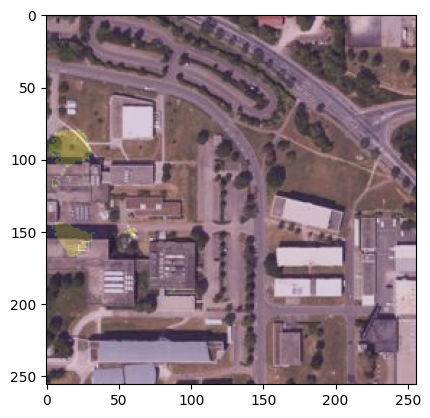

In [23]:
rand_area = np.array(Image.open(pred_img))

plt.imshow(rand_area)
plt.imshow(pred_mask, alpha=0.2);

In [13]:


# Pfad zu Ihren Bildern
bilder_pfad = '/content/gdrive/MyDrive/Capstone/Data/wuerzburg_data'

# Liste aller Dateien im Bilderpfad
dateinamen = os.listdir(bilder_pfad)

# DataFrame initialisieren
df = pd.DataFrame(columns=['Bildname', 'Pixelanzahl'])

for dateiname in dateinamen:
    bild_pfad = os.path.join(bilder_pfad, dateiname)

    # Überprüfen, ob der Pfad auf ein Bild zeigt
    if os.path.isfile(bild_pfad) and bild_pfad.endswith('.jpg'):
        # Vorhersage der Maske
        try:
            pred_mask = learn_app.predict(bild_pfad)[0]
            # Zählen der Pixel, die zur Klasse "park" gehören
            pixelanzahl = np.sum(np.array(pred_mask) == 1)
            # Hinzufügen der Daten zum DataFrame
            df = pd.concat([df, pd.DataFrame({'Bildname': [dateiname], 'Pixelanzahl': [pixelanzahl]})], ignore_index=True)
        except Exception as e:
            print(f"Fehler bei der Verarbeitung des Bildes {dateiname}: {e}")

# Gesamtfläche berechnen
gesamtflaeche = df['Pixelanzahl'].sum()
print(f"Gesamtfläche: {gesamtflaeche} Pixel")


Gesamtfläche: 77007 Pixel


In [24]:
# Pfad zu Ihren Bildern
bilder_pfad = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# Liste aller Dateien im Bilderpfad
dateinamen = os.listdir(bilder_pfad)

# DataFrame initialisieren
df_munich = pd.DataFrame(columns=['Bildname', 'Pixelanzahl'])

for dateiname in dateinamen:
    bild_pfad = os.path.join(bilder_pfad, dateiname)

    # Überprüfen, ob der Pfad auf ein Bild zeigt
    if os.path.isfile(bild_pfad) and bild_pfad.endswith('.jpg'):
        # Vorhersage der Maske
        try:
            pred_mask = learn_app.predict(bild_pfad)[0]
            # Zählen der Pixel, die zur Klasse "park" gehören
            pixelanzahl = np.sum(np.array(pred_mask) == 1)
            # Hinzufügen der Daten zum DataFrame
            df_munich = pd.concat([df_munich, pd.DataFrame({'Bildname': [dateiname], 'Pixelanzahl': [pixelanzahl]})], ignore_index=True)
        except Exception as e:
            print(f"Fehler bei der Verarbeitung des Bildes {dateiname}: {e}")

# Gesamtfläche berechnen
gesamtflaeche_munich = df_munich['Pixelanzahl'].sum()
print(f"Gesamtfläche: {gesamtflaeche_munich} Pixel")

Gesamtfläche: 1823604 Pixel


In [25]:
print(df_munich)

           Bildname Pixelanzahl
0    32700_5330.jpg           0
1    32701_5331.jpg          38
2    32697_5328.jpg        6531
3    32698_5328.jpg          29
4    32698_5329.jpg          16
..              ...         ...
366  32699_5335.jpg         531
367  32699_5337.jpg           0
368  32699_5339.jpg           0
369  32700_5339.jpg       19924
370  32701_5336.jpg           0

[371 rows x 2 columns]


In [14]:
# Anzeigen des gesamten DataFrame
print(df)


          Bildname Pixelanzahl
0   32562_5519.jpg         946
1   32568_5515.jpg           4
2   32570_5514.jpg        1026
3   32562_5513.jpg           0
4   32572_5516.jpg           0
5   32565_5520.jpg           0
6   32568_5509.jpg         119
7   32567_5517.jpg        2688
8   32563_5511.jpg           0
9   32563_5516.jpg           0
10  32570_5516.jpg       14995
11  32570_5517.jpg        3936
12  32566_5516.jpg         435
13  32570_5512.jpg        3362
14  32569_5519.jpg         227
15  32564_5515.jpg        3231
16  32568_5511.jpg        5968
17  32568_5517.jpg           0
18  32568_5507.jpg           0
19  32565_5519.jpg           0
20  32567_5511.jpg       10719
21  32568_5518.jpg           0
22  32570_5513.jpg           0
23  32567_5520.jpg           0
24  32570_5515.jpg         317
25  32564_5516.jpg        1208
26  32563_5513.jpg           0
27  32567_5516.jpg        3166
28  32566_5517.jpg           9
29  32569_5517.jpg        3135
30  32572_5515.jpg           0
31  3256

In [31]:
# Angenommene Auflösung: 1 Pixel = 1 Quadratmeter
pixel_zu_qm = 1

# Auflösung: 1 Pixel = 0,5 Meter (Seitenlänge eines Pixels)
#pixel_zu_qm = 0.5 * 0.5  # 0,25 Quadratmeter pro Pixel



#München


# Berechnen der Fläche in Quadratmetern für jede Zeile im DataFrame
df_munich['Fläche in qm'] = df_munich['Pixelanzahl'] * pixel_zu_qm


# Berechnen der Gesamtfläche in Quadratmetern
gesamtflaeche_qm_munich = df_munich['Fläche in qm'].sum()
print(f"Gesamtfläche an Parks in München in Quadratmetern: {gesamtflaeche_qm_munich} qm")

#print(df_munich)


#Würzburg


# Berechnen der Fläche in Quadratmetern für jede Zeile im DataFrame
df['Fläche in qm'] = df['Pixelanzahl'] * pixel_zu_qm

# Anzeigen des aktualisierten DataFrame
#print(df)

# Berechnen der Gesamtfläche in Quadratmetern
gesamtflaeche_qm_wuerzburg = df['Fläche in qm'].sum()
print(f"Gesamtfläche an Parks in Würzburg in Quadratmetern: {gesamtflaeche_qm_wuerzburg} qm")

Gesamtfläche an Parks in München in Quadratmetern: 1823604 qm
Gesamtfläche an Parks in Würzburg in Quadratmetern: 77007 qm


In [32]:
# Annahme: Jedes Bild hat eine Größe von 250x250 Pixeln
pixel_pro_bild = 250 * 250

# Anzahl der Bilder für Würzburg und München
anzahl_bilder_wuerzburg = len(df)
anzahl_bilder_muenchen = len(df_munich)

# Gesamtzahl der Pixel in allen Bildern für Würzburg und München
gesamt_pixel_wuerzburg = anzahl_bilder_wuerzburg * pixel_pro_bild
gesamt_pixel_muenchen = anzahl_bilder_muenchen * pixel_pro_bild

# Berechnung des Prozentsatzes der Park-Pixel für Würzburg
prozent_parks_wuerzburg = (df['Pixelanzahl'].sum() / gesamt_pixel_wuerzburg) * 100

# Berechnung des Prozentsatzes der Park-Pixel für München
prozent_parks_muenchen = (df_munich['Pixelanzahl'].sum() / gesamt_pixel_muenchen) * 100

# Ausgabe der Ergebnisse
print(f"Prozentsatz der Parks in Würzburg: {prozent_parks_wuerzburg:.2f}%")
print(f"Prozentsatz der Parks in München: {prozent_parks_muenchen:.2f}%")


Prozentsatz der Parks in Würzburg: 2.80%
Prozentsatz der Parks in München: 7.86%
